In [1]:
library(data.table)
library(pracma)
load('../data/mutation_type_pd.rda')

In [2]:
birthrate <- function(nd, np, sd, sp) {
    return(((1+sd)^nd)/((1+sp)^np))
}

In [3]:
delta_ncells <- function(B, D, tau, ncells) {
    return (max(ncells + rbinom(1,ncells,min(B*tau,1))-rbinom(1,ncells,min(D*tau,1)),0))
}

### Define parameters

In [4]:
# Initial number of cells
N0 <- 1e3
# Probability of transposition per generation per cell
mu <- 0.01
# Time resolution: number of time steps per generation
tau <- 5
tau <- 1/tau
# Number of time steps
NT <- 1e4
# Buffer size of population data object; represents the max possible number of clones in the population
maxNClones <- 5000

   user  system elapsed 
  6.972   0.000   6.973 

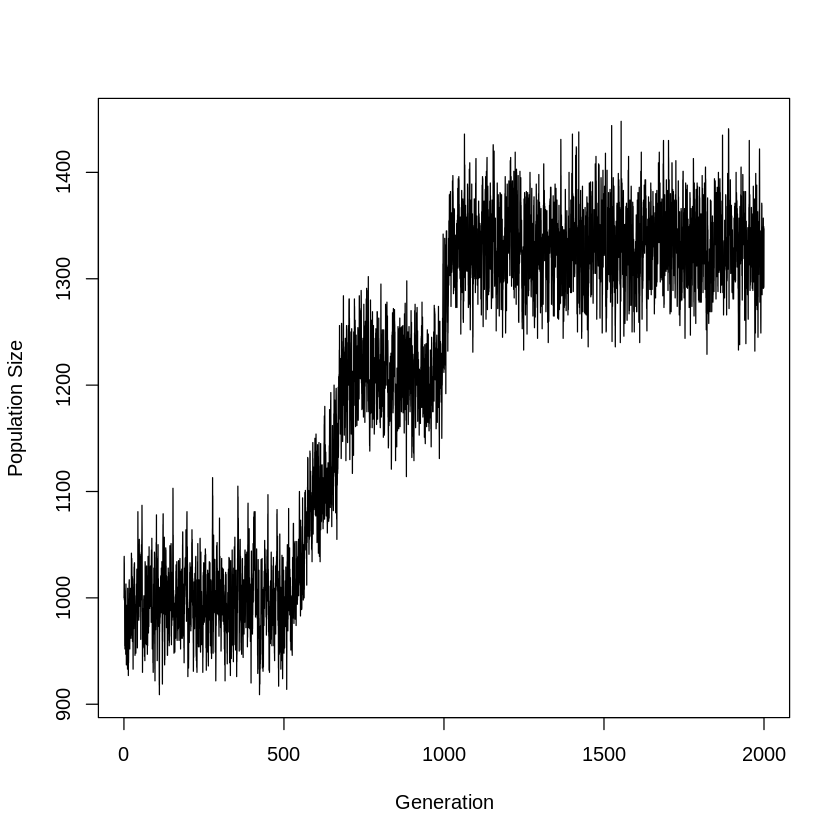

In [8]:
Pop <- data.table(ncells=rep(0,maxNClones),nd=rep(0,maxNClones),np=rep(0,maxNClones),B=rep(0,maxNClones))
Pop[1]$ncells = N0
Pop[1]$nd = 0
Pop[1]$np = 0
Pop[1]$B = 1

sd <- .1
sp <- .01
N <- rep(0,NT)

ptm <- proc.time()
for (ii in 1:NT) {

    N[ii] <- sum(Pop$ncells) # get current number of cells
    if (N[ii]>=5*N0) {
        break
    }
    D <- N[ii]/N0            # compute death rate
    ntrans <- rbinom(1,N[ii],mu*tau) # sample total number of transpositions for current timestep
    if (ntrans > 0) {
        types <- sample(1:3,ntrans,replace=TRUE,prob=pdfinal) # sample mutation types
        if (length(which(types!=3))>0) { # if any passenger or driver mutations exist
            types <- types[types!=3] # reduce array of types to only passenger and drivers
            nmu <- length(types) # total number of passenger and drivers
            
            sampctr <- sample(rep(1:maxNClones,Pop$ncells),nmu,replace=FALSE) # list clone id of each cell; sample without replacement
            ctab <- table(sampctr)
            cids <- as.integer(names(ctab)) # get row ids of sampled clones
            set(Pop,cids,1L,Pop[cids,1L] - as.integer(ctab)) # remove cells from sampled clones
            
            tmp <- which(Pop$ncells==0)[1] # find first row of the data table with ncells==0
            # Populate the new rows representing new clones
            Pop[tmp:(tmp+nmu-1),c("ncells","nd","np"):=list(1, Pop[sampctr]$nd+((types==1)*1), Pop[sampctr]$np+((types==2)*1))] 
            Pop[tmp:(tmp+nmu-1), B := mapply(birthrate, nd, np, sd, sp)]
        }
    }
    
    Pop[which(Pop$ncells>0), ncells:=mapply(delta_ncells, B, D, tau, ncells)] # update number of cells for all clones
    Pop <- Pop[order(Pop$ncells,decreasing=TRUE),] # order data.table by ncells
    
}
proc.time() - ptm
# png(paste0('~/Desktop/',as.character(jj),'.png'))
# plot((1:NT)*tau,movavg(N,1/tau,'s'),type='l',xlab='Generation',ylab='Population Size')
plot((1:NT)*tau,N,type='l',xlab='Generation',ylab='Population Size')
# dev.off()
